In [31]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque
import random
import gym
import matplotlib
import matplotlib.pyplot as plt

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [32]:
class dqn(nn.Module):
    def __init__(self, observation_dim, action_dim):
        super(dqn, self).__init__()
        self.observation_dim = observation_dim
        self.action_dim = action_dim

        self.fc1 = nn.Linear(self.observation_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, self.action_dim)

    def forward(self, observation):
        x = self.fc1(observation)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

    def get_action(self, observation, epsilon):
        if random.random() > epsilon:
            q_value = self.forward(observation)
            action = q_value.max(1)[1].data[0].item()
        else:
            action = random.choice(list(range(self.action_dim)))
        return action

In [33]:

class replay_buffer(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=self.capacity)

    def store(self, observation, action, reward, next_observation, done, ):
        observation = np.expand_dims(observation, 0)
        next_observation = np.expand_dims(next_observation, 0)
        self.memory.append([observation, action, reward, next_observation, done])

    def sample(self, size):
        batch = random.sample(self.memory, size)
        observation, action, reward, next_observation, done = zip(* batch)
        return np.concatenate(observation, 0), action, reward, np.concatenate(next_observation, 0), done

    def __len__(self):
        return len(self.memory)

In [34]:
def training(buffer, batch_size, model, optimizer, gamma, loss_fn):
    observation, action, reward, next_observation, done = buffer.sample(batch_size)

    observation = torch.FloatTensor(observation)
    action = torch.LongTensor(action)
    reward = torch.FloatTensor(reward)
    next_observation = torch.FloatTensor(next_observation)
    done = torch.FloatTensor(done)

    q_values = model.forward(observation)
    next_q_values = model.forward(next_observation)

    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value = next_q_values.max(1)[0].detach()
    expected_q_value = reward + next_q_value * (1 - done) * gamma

    loss = loss_fn(q_value, expected_q_value.detach())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [35]:
epsilon_init = 0.9
epsilon_min = 0.01
decay = 0.995
capacity = 10000
exploration = 5000
batch_size = 64
episode = 1000000
render = True
learning_rate = 1e-3
gamma = 0.99
loss_fn = nn.MSELoss()

env = gym.make('CartPole-v1')
env = env.unwrapped
action_dim = env.action_space.n
observation_dim = env.observation_space.shape[0]

model = dqn(observation_dim, action_dim)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
buffer = replay_buffer(capacity)
epsilon = epsilon_init
weight_reward = None

for i in range(episode):
    obs = env.reset()
    if epsilon > epsilon_min:
        epsilon = epsilon * decay
    reward_total = 0
    if render:
        env.render()
    while True:
        action = model.get_action(torch.FloatTensor(np.expand_dims(obs, 0)), epsilon)
        train_flag = False
        next_obs, reward, done, info = env.step(action)
        if render:
            env.render()
        buffer.store(obs, action, reward, next_obs, done)
        reward_total += reward
        obs = next_obs
        if len(buffer) > exploration:
            training(buffer, batch_size, model, optimizer, gamma, loss_fn)
            train_flag = True
        if done:
            if not weight_reward:
                weight_reward = reward_total
            else:
                weight_reward = 0.99 * weight_reward + 0.01 * reward_total
            print('episode: {}  reward: {}  epsilon: {:.2f}  train:  {}  weight_reward: {:.3f}'.format(i+1, reward_total, epsilon, train_flag, weight_reward))
            break

episode: 1  reward: 14.0  epsilon: 0.90  train:  False  weight_reward: 14.000
episode: 2  reward: 11.0  epsilon: 0.89  train:  False  weight_reward: 13.970
episode: 3  reward: 19.0  epsilon: 0.89  train:  False  weight_reward: 14.020
episode: 4  reward: 30.0  epsilon: 0.88  train:  False  weight_reward: 14.180
episode: 5  reward: 24.0  epsilon: 0.88  train:  False  weight_reward: 14.278
episode: 6  reward: 12.0  epsilon: 0.87  train:  False  weight_reward: 14.256
episode: 7  reward: 20.0  epsilon: 0.87  train:  False  weight_reward: 14.313
episode: 8  reward: 27.0  epsilon: 0.86  train:  False  weight_reward: 14.440
episode: 9  reward: 24.0  epsilon: 0.86  train:  False  weight_reward: 14.535
episode: 10  reward: 14.0  epsilon: 0.86  train:  False  weight_reward: 14.530
episode: 11  reward: 24.0  epsilon: 0.85  train:  False  weight_reward: 14.625
episode: 12  reward: 21.0  epsilon: 0.85  train:  False  weight_reward: 14.689
episode: 13  reward: 18.0  epsilon: 0.84  train:  False  weig

KeyboardInterrupt: 

In [22]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 0.005
LR = 1e-4
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)


optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def actB(self, observation, epsilon = 0.3):
    global steps_done
    steps_done += 1
    
    A = np.ones(n_actions, dtype=float) * (epsilon/n_actions)
    temp = self.forward(observation)
    best_action = temp.max(1)[1].data[0].item()
    A[best_action] += 1.0 - epsilon   
    return A

def actPi(self, observation, epsilon = 0.1):
    A = np.ones(n_actions, dtype=float) * (epsilon/n_actions)
    temp = self.forward(observation)
    best_action = temp.max(1)[1].data[0].item()
    A[best_action] += 1.0 - epsilon   
    return A

def select_action(state,epsilon = 0.3):
    global steps_done
    sample = random.random()
    steps_done += 1
    return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [25]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

KeyboardInterrupt: 

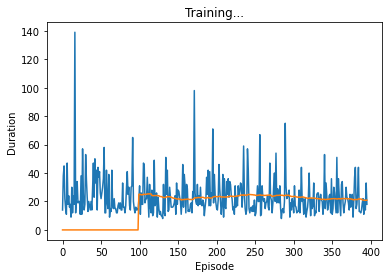

In [26]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

      

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()